 # Assignment 2 - Modern CNNs (NiN)
*This notebook was run by Arsyi Syarief Aziz (H071191003) for the Introduction to Deep Learning course (Unhas) taught by Dr. Risman Adnan.*

This is part 3/7 of this week's assignment. In this notebook, I will attempt to implement NiN.

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim
import torch.nn.functional as F

In [2]:
cuda = torch.device('cuda')

## Importing Dataset

I will use the MNIST dataset to train and test the model in this notebook. Because MNIST contains images of shape 28x28 pixels and because NiN accepts images of size 244x244 pixels, I will upscale each image in the dataset to 244x244 pixels.

In [3]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Resize(224)]) # Upscale to 244x224 pixels
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_loader = torch.utils.data.DataLoader(
                 dataset=training_data,
                 batch_size=128,
                 shuffle=True,
                 num_workers=2,
                 pin_memory=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_data,
                batch_size=512,
                shuffle=False,
                num_workers=2,
                pin_memory=True)

Below are nine samples of the dataset

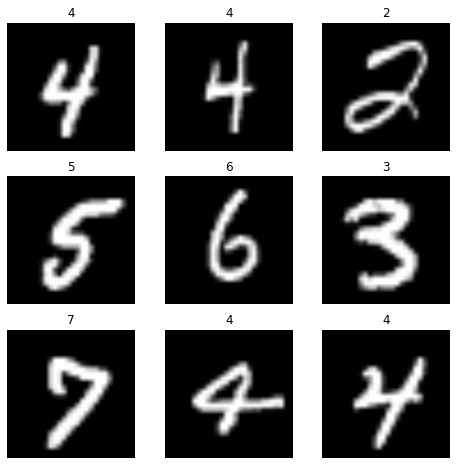

In [5]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Definining Helper Functions

The function below will be used to train the neural network

In [6]:
def train(net, train_loader, epochs=10, lr=0.001): 

    optimizer = optim.Adam(net.parameters())
    criterion = nn.CrossEntropyLoss()

    net.to(cuda)
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0

        net.train()
        for X, y in train_loader:
            X, y = X.to(cuda), y.to(cuda)

            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)

            # forward + backward + optimize
            outputs = net(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f'Epoch: {epoch + 1}, loss: {running_loss / len(train_loader.dataset):.6f}')

    print('Finished Training')
    total, correct = test(net, train_loader)
    print(f'Train accuracy: {(correct/total)*100}%')

The function below will be used to calculate the neural network's test accuracy.

In [7]:
def test(net, test_loader):
    
    total = 0
    correct = 0

    for X, y in test_loader:
        net.eval()
        X, y = X.to(cuda), y.to(cuda)

        y_hat = net(X).argmax(axis=1)
        total += X.shape[0]
        correct += (y_hat == y).sum()

    return total, correct
  

## NiN

NiN (Network in Network) uses a slightly different approach than the previous two architectures, in which it uses NiN blocks to integrate two fully connected layers with a convolutional layer. These fully connected layers are applied at each pixel location (one for height and one for width). Equivalently, these fully connected layers can be seen as convolutional layers with kernel size 1x1. 

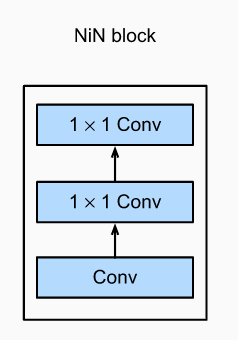

Another difference is that the last layers of the NiN model are not fully connected layers. Instead, NiN sets the number of output channels of the last NiN block equal to the number of label classes.

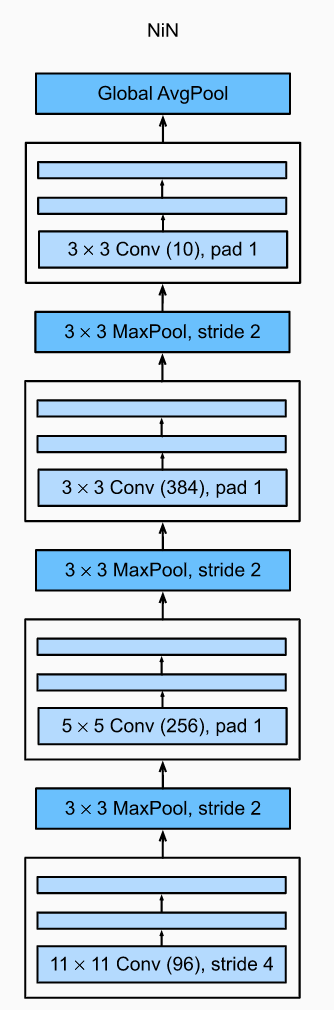

In the picture above, it can be seen that the NiN model consists of several NiN blocks, where in between each NiN block is a max-pooling layer, and after the final NiN block is a global average pooling layer.

Below is an implementation of a NiN block with the ReLU activation function.

In [8]:
def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

Below is an implementation of a NiN model with four NiN blocks, each with output channels of size 96, 256, 384, and 10, respectively.

In [9]:
nin = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # There are 10 label classes
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    # Transform the four-dimensional output into two-dimensional output with a
    # shape of (batch size, 10)
    nn.Flatten())

I will train VGGNet with a learning rate of 0.001 and a total of 10 epochs.

In [10]:
train(nin, train_loader, lr=0.001, epochs=10) 

Epoch: 1, loss: 0.010857
Epoch: 2, loss: 0.002190
Epoch: 3, loss: 0.001142
Epoch: 4, loss: 0.000872
Epoch: 5, loss: 0.000720
Epoch: 6, loss: 0.000651
Epoch: 7, loss: 0.000601
Epoch: 8, loss: 0.000531
Epoch: 9, loss: 0.000490
Epoch: 10, loss: 0.000498
Finished Training
Train accuracy: 98.84166717529297%


In [11]:
total, correct = test(nin, test_loader)  

In [12]:
print(f"Test Accuracy: {(correct/total)*100}% ({correct}/{total})")

Test Accuracy: 98.75999450683594% (9876/10000)


As you can see, the trained NiN model has a test accuracy of 98.76%.

## Visualizing Predictions

Below are five visual representations of the NiN model's predictions.

In [13]:
def viz_results(net, dataset, num_samples=5):
    net.cpu()
    for i, (x, y) in enumerate(iter(dataset), 1):
        if i <= num_samples:
            
            x, y = x, y
            x = x.reshape(1, 1, x.shape[1], x.shape[2])

            y_hat = net(x).argmax()

            plt.imshow(x.reshape(x.shape[1], x.shape[2], -1).squeeze())
            plt.title(f'{i}. Actual: {y}; Predicted: {y_hat}')
            plt.show()
        else:
            break

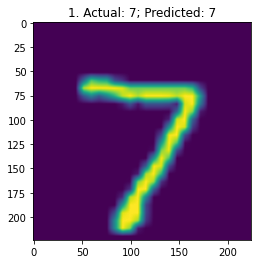

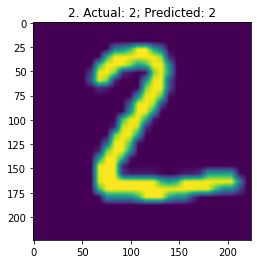

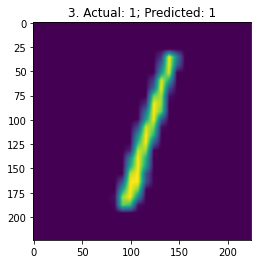

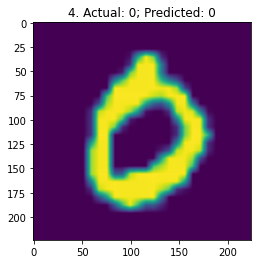

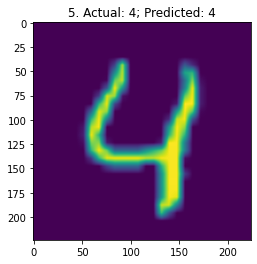

In [14]:
viz_results(nin, test_data)